In [6]:
from birdclef.spark import get_spark
from pyspark.sql import functions as F

spark = get_spark(cores=4, driver_memory="12g")
spark

25/02/23 17:17:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [26]:
import os

input_path = os.path.expanduser(
    "~/shared/birdclef/processed/birdclef-2024/unlabeled_soundscapes/embed/birdnet"
)
df = spark.read.parquet(input_path)
df.printSchema()
df.count()

root
 |-- name: string (nullable = true)
 |-- chunk_5s: long (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: double (containsNull = true)



402036

In [11]:
df.select("name").distinct().show(n=5)

+--------------+
|          name|
+--------------+
| 907443416.ogg|
| 661943621.ogg|
|1699850395.ogg|
|1720692172.ogg|
| 312908592.ogg|
+--------------+
only showing top 5 rows



In [15]:
import numpy as np

# take 10% sample of the data and plot it
subset = df.where(F.crc32("name") % 10 == 0)
print("count", subset.count())
emb = np.stack(subset.select("embedding").toPandas().embedding)
emb.shape

count 39658


(39658, 1024)

In [16]:
import pacmap

model = pacmap.PaCMAP()
g = model.fit_transform(emb, init="pca")

/tmp/ipykernel_1310970/1358488126.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(g[:, 0], g[:, 1], cmap="Spectral", s=0.6)


Text(0.5, 1.0, 'soundscape 5s embeddings, pacmap, 10pct sample')

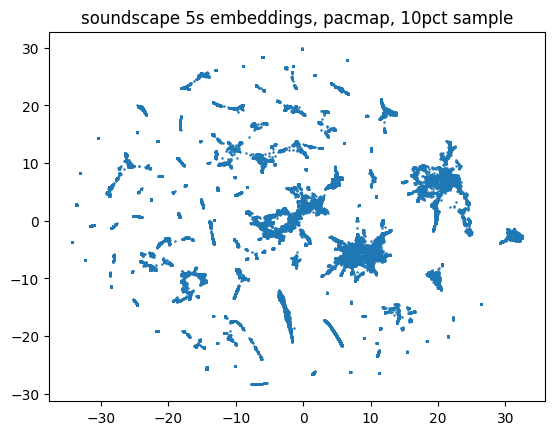

In [22]:
import matplotlib.pyplot as plt

plt.scatter(g[:, 0], g[:, 1], cmap="Spectral", s=0.6)
plt.title("soundscape 5s embeddings, pacmap, 10pct sample")

In [37]:
# get a random track
name = df.select("name").first().name

data = np.stack(
    df.where(F.col("name") == name)
    .orderBy("chunk_5s")
    .select("embedding")
    .toPandas()
    .embedding
)
data.shape

(48, 1024)

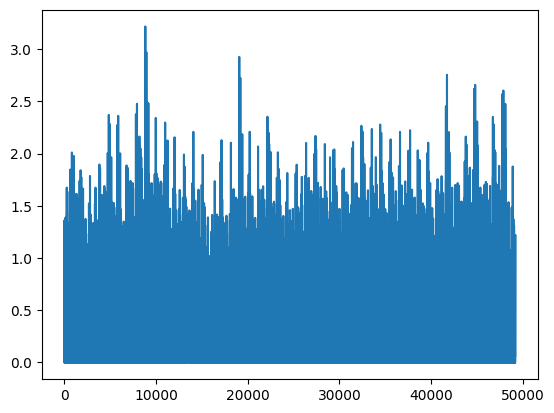

In [40]:
import stumpy

y = data.reshape(-1)
plt.plot(y)
plt.show()

Note: `n_components != 2` have not been thoroughly tested.


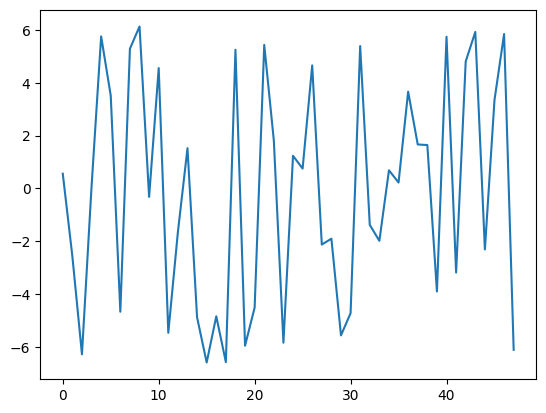

In [41]:
# let's also get component with pacmap
g = pacmap.PaCMAP(n_components=1).fit_transform(data)
plt.plot(g)
plt.show()

In [42]:
m = 1024
mp = stumpy.stump(y, m)

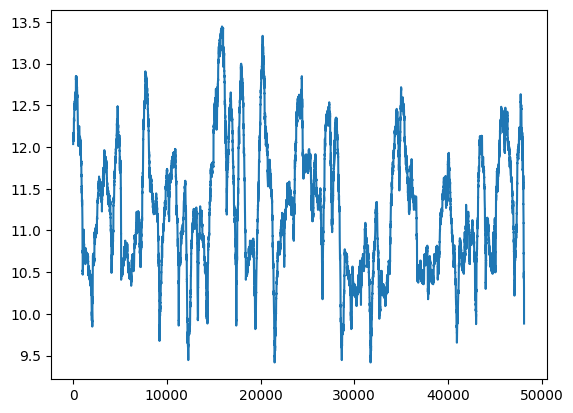

In [45]:
plt.plot(mp[:, 0])
plt.show()